### Case Study : Recommendation System

#### Problem Statement:
To design and implement movie recommendation system to provide most relevant recommendations to the user

#### Input data:
1. Movies dataset
2. Users dataset
3. Ratings dataset

### Import Libraries

In [99]:
#Import all the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from surprise import KNNWithMeans 
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix

ModuleNotFoundError: No module named 'surprise'

In [101]:
# Set Global Parameters

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style('darkgrid')

In [102]:
# Read the datasets into the pandas dataframe

df1 = pd.read_fwf('zee_movies.dat', encoding='ISO-8859-1')
df2 = pd.read_fwf('zee_users.dat', encoding='ISO-8859-1')
df3 = pd.read_fwf('zee_ratings.dat', encoding='ISO-8859-1')

In [4]:
# Copy Dataframe to working dataframe

movies = df1.copy()
users = df2.copy()
ratings = df3.copy()

#### Perform EDA

In [5]:
# Display shape of all the datasets

movies.shape, users.shape, ratings.shape

((3883, 3), (6040, 1), (1000209, 1))

In [6]:
# Get the glimpse of movies dataset

movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [7]:
# Get the glimpse of Users dataset

users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [8]:
# Get the glimpse of rating dataset

ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [9]:
# Define a function for data formating and data cleaning

def func_lambda(x,i):
    if x == None:
        return None
    
    try:
        return x[i]
    except IndexError:
        return None
    else:
        return None

In [10]:
# Define a function to typecast the data into integer format

def func_convertInt(x):
    try:
        return x.astype('int')
    except:
        return 0

#### Data cleaning and formatting of movies dataset

In [11]:
# Split the raw movies dataset and prepare the dataframe with clean labels

movies['MovieID'] = movies['Movie ID::Title::Genres'].str.split('::').apply(lambda x: func_lambda(x,0))
movies['Title'] = movies['Movie ID::Title::Genres'].str.split('::').apply(lambda x: func_lambda(x,1))
movies['Genres'] = movies['Movie ID::Title::Genres'].str.split('::').apply(
                                                                lambda x: 
                                                                func_lambda(x, 2)).str.split('|')

In [12]:
# Keep the copy of the movies dataset for future use and referencing to the movie Title

movies_non_explode = movies.copy()
movies_non_explode = movies_non_explode.loc[~movies_non_explode['Genres'].isna()]
movies_non_explode = movies_non_explode[['MovieID', 'Title','Genres']]
movies_non_explode['MovieID'] = movies_non_explode['MovieID'].astype('int')

In [13]:
# Explode the Genres label

movies = movies[['MovieID', 'Title', 'Genres']]
movies = movies.explode('Genres')

In [14]:
# Feature engg to create Release Year label

release = movies['Title'].str.split(' ').apply(lambda x: func_lambda(x,-1))
release = release.str.split('(').apply(lambda x: func_lambda(x,-1))
release = release.str.split(')').apply(lambda x: func_lambda(x,0))
movies['ReleaseYear'] = pd.Series(release)
movies = movies.loc[movies['ReleaseYear'].str.isdigit()]

In [15]:
# Get the glimpse of cleaned movies dataset

movies.head()

,MovieID,Title,Genres,ReleaseYear
0,1,Toy Story (1995),Animation,1995
0,1,Toy Story (1995),Children's,1995
0,1,Toy Story (1995),Comedy,1995
1,2,Jumanji (1995),Adventure,1995
1,2,Jumanji (1995),Children's,1995


#### Data cleaning and formatting of users dataset

In [16]:
# Split the raw data and format that to the necessary labels

users['UserID'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 0))
users['Gender'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 1))
users['Age'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 2))
users['Occupation'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 3))
users['Zip-code'] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::').apply(
                                                                lambda x:
                                                                func_lambda(x, 4))

In [17]:
# Prepare the final users dataframe

users = users[['UserID','Gender','Age','Occupation','Zip-code']]

In [18]:
# Get the glimpse of cleaned users dataset

users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


#### Data cleaning and formatting of ratings dataset

In [19]:
# Split row ratings data into proper labels

ratings['UserID'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,0))
ratings['MovieID'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,1))
ratings['Rating'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,2))
ratings['Timestamp'] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::').apply(
                                                        lambda x:
                                                        func_lambda(x,3))

ratings['Timestamp'] = ratings['Timestamp'].astype('int')
ratings['Hour'] = ratings['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)

In [20]:
# Prepare final ratings dataset

ratings = ratings[['UserID','MovieID','Rating','Hour']]

In [21]:
# Get the glimpse of final ratings dataset

ratings.head()

,UserID,MovieID,Rating,Hour
0,1,1193,5,3
1,1,661,3,4
2,1,914,3,4
3,1,3408,4,3
4,1,2355,5,5


### Missing value check and treatment

In [22]:
## Null values check in Users dataset

users.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [23]:
## Null values check in Ratings dataset

ratings.isna().sum()

UserID     0
MovieID    0
Rating     0
Hour       0
dtype: int64

In [24]:
## Null values check in Movies dataset

movies.isna().sum()

MovieID         0
Title           0
Genres         16
ReleaseYear     0
dtype: int64

In [25]:
## Persentage of null values in Movies dataset

movies.isna().sum()/movies.shape[0]*100

MovieID        0.000000
Title          0.000000
Genres         0.251691
ReleaseYear    0.000000
dtype: float64

In [26]:
# Check the null records having null values in Genres

movies.loc[movies['Genres'].isna()]

,MovieID,Title,Genres,ReleaseYear
197,199,"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964):",None,1964
464,468,"Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995",None,1995
720,729,"Institute Benjamenta, or This Dream People Call Human Life (1995):",None,1995
1134,1150,"Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)",None,1982
1160,1176,"Double Life of Veronique, The (La Double Vie de Véronique) (1991)",None,1991
1341,1362,"Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (19",None,19
1950,2019,Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (195,None,195
2522,2591,Jeanne and the Perfect Guy (Jeanne et le garçon formidable) (1998,None,1998
2563,2632,"Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965",None,1965
2721,2790,"Final Conflict, The (a.k.a. Omen III: The Final Conflict) (1981):",None,1981


In [27]:
# Drop null values as there are only 0.25% of Genre are missing

movies = movies.loc[~movies['Genres'].isna()]

In [28]:
## Verify Movies Dataset after dropping null values 

movies.isna().sum()

MovieID        0
Title          0
Genres         0
ReleaseYear    0
dtype: int64

### 

### Merging all input datasets into single dataframe

In [29]:
### Merge Movies, Users, and Ratings datasets

df = movies.merge(ratings, how='inner', on='MovieID')
df = df.merge(users, how='inner', on= 'UserID')

In [30]:
## Get glimpse of merged single dataframe

df.head()

,MovieID,Title,Genres,ReleaseYear,UserID,Rating,Hour,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation,1995,1,5,5,F,1,10,48067
1,1,Toy Story (1995),Children's,1995,1,5,5,F,1,10,48067
2,1,Toy Story (1995),Comedy,1995,1,5,5,F,1,10,48067
3,48,Pocahontas (1995),Animation,1995,1,5,5,F,1,10,48067
4,48,Pocahontas (1995),Children's,1995,1,5,5,F,1,10,48067


In [31]:
# Shape of merged dataset

df.shape

(2060031, 11)

In [32]:
# Rearrange columns and drop unwanted lables

df = df[['UserID',
         'Gender',
         'Age',
         'Occupation',
         'Zip-code',
         'MovieID',
         'Title',
         'Genres',
         'Rating',
         'Hour',
         'ReleaseYear']]

In [33]:
# Get the glimpse of the dataset

df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Title,Genres,Rating,Hour,ReleaseYear
0,1,F,1,10,48067,1,Toy Story (1995),Animation,5,5,1995
1,1,F,1,10,48067,1,Toy Story (1995),Children's,5,5,1995
2,1,F,1,10,48067,1,Toy Story (1995),Comedy,5,5,1995
3,1,F,1,10,48067,48,Pocahontas (1995),Animation,5,5,1995
4,1,F,1,10,48067,48,Pocahontas (1995),Children's,5,5,1995


### EDA and univariate/bivariate analysis

In [34]:
# check for null values in final dataset

df.isna().sum()

UserID         0
Gender         0
Age            0
Occupation     0
Zip-code       0
MovieID        0
Title          0
Genres         0
Rating         0
Hour           0
ReleaseYear    0
dtype: int64

In [35]:
# Get column details using dataframe info()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060031 entries, 0 to 2060030
Data columns (total 11 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   UserID       object
 1   Gender       object
 2   Age          object
 3   Occupation   object
 4   Zip-code     object
 5   MovieID      object
 6   Title        object
 7   Genres       object
 8   Rating       object
 9   Hour         int64 
 10  ReleaseYear  object
dtypes: int64(1), object(10)
memory usage: 188.6+ MB


In [36]:
# Get Stat using dataframe describe()

df.describe()

,Hour
count,2.060031e+06
mean,9.716971e+00
std,7.290599e+00
min,0.000000e+00
25%,4.000000e+00
50%,8.000000e+00
75%,1.500000e+01
max,2.300000e+01


In [37]:
# Get categorial variable stats using describe()

df.describe(include='object')

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Title,Genres,Rating,ReleaseYear
count,2060031,2060031,2060031,2060031,2060031,2060031,2060031,2060031,2060031,2060031
unique,6040,2,7,21,3439,3682,3682,63,5,81
top,4169,M,25,4,94110,1580,Men in Black (1997),Comedy,4,1999
freq,3970,1563214,815051,271976,7665,10152,10152,353032,715225,150709


### Inference from describe()
1. Top user : 4269
2. Top Gender: Male
3. Top Age: 25
4. Top Occupation: 4
5. Top Zip-code: 94110
6. Top movie id: 1580
7. Top movie title: Men in Black(1997)
8. Top Genre: Comedy
9. Top Rating: 4
10.Top Release year: 1999

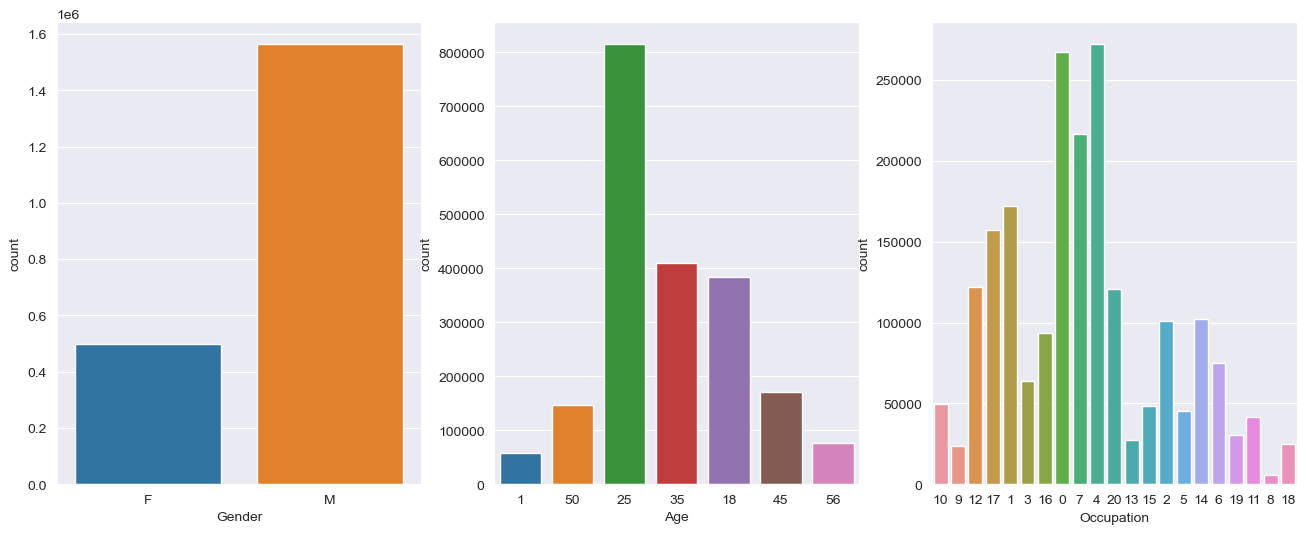

In [38]:
# Count plot of Male and Female
# Count plot of Age
# Count plot of Occupation

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
sns.countplot(data=df, x='Gender')
plt.subplot(1,3,2)
sns.countplot(data=df, x='Age')
plt.subplot(1,3,3)
sns.countplot(data=df, x='Occupation')
plt.show()

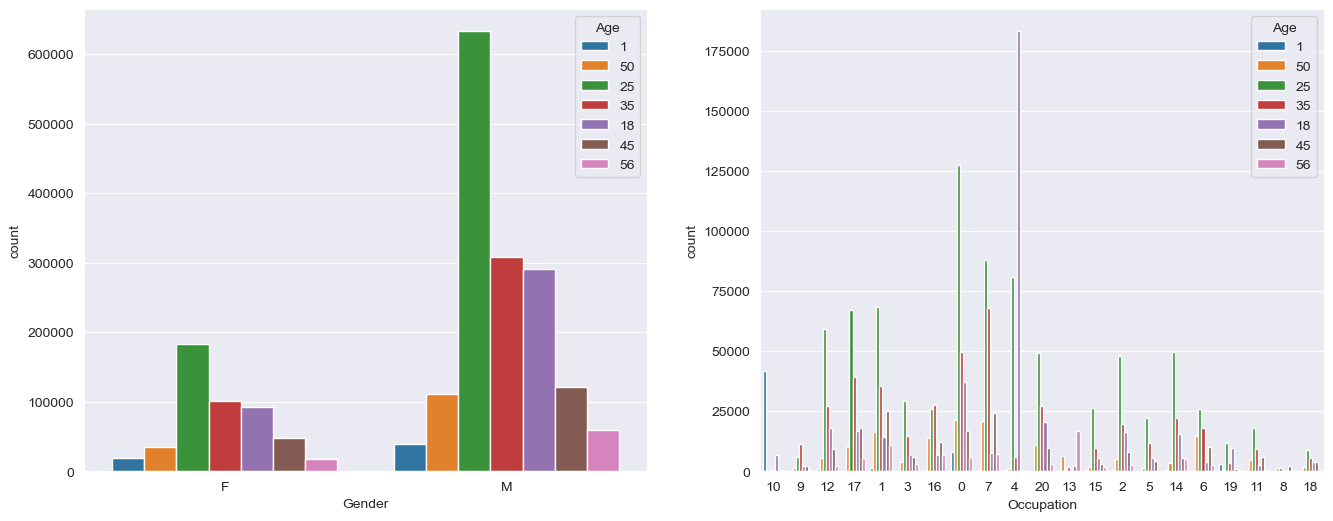

In [39]:
# Age wise countplot w.r.t to Gender
# Age wise countplot w.r.t to Occupation

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.countplot(data=df, x='Gender', hue='Age')
plt.subplot(1,2,2)
sns.countplot(data=df, x='Occupation', hue='Age')
plt.show()

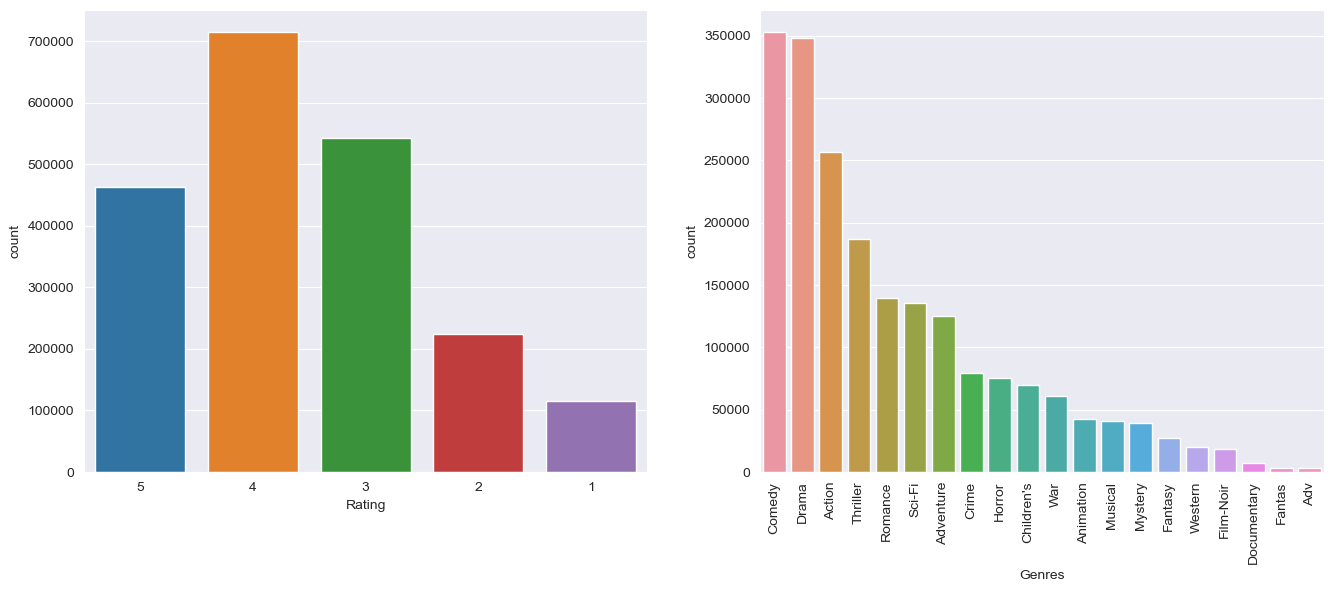

In [40]:
# Countplot of Rating
# Countplot of Genres

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.countplot(data=df, x='Rating')
plt.subplot(1,2,2)
sns.countplot(data=df, x='Genres', order=df['Genres'].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.show()

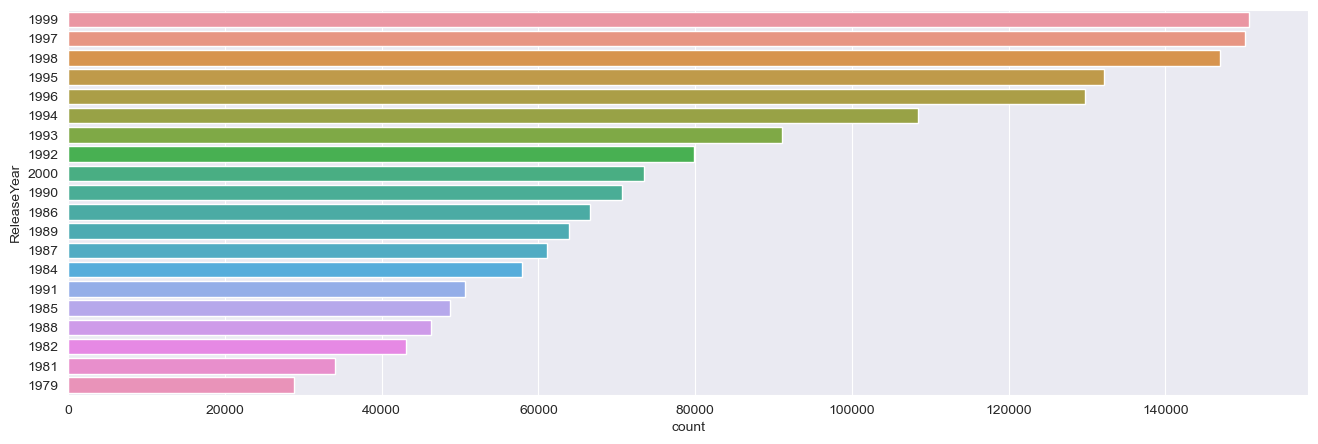

In [41]:
# Countplot of Release Year

plt.figure(figsize=(16,5))
sns.countplot(data=df, y='ReleaseYear',
            order= df['ReleaseYear'].value_counts().iloc[:20].index)

plt.show()

<Axes: xlabel='count', ylabel='Hour'>

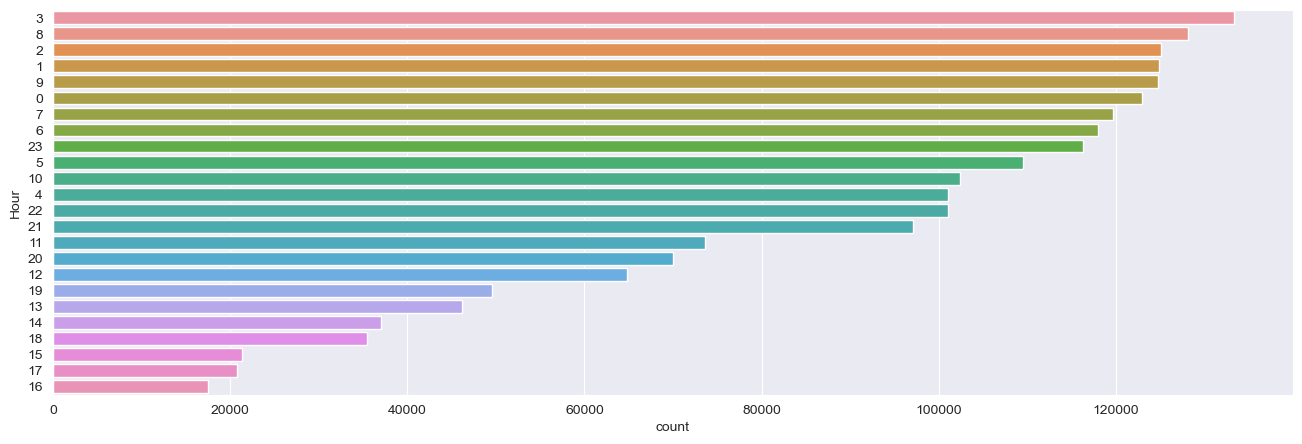

In [42]:
# Counplot of Hours

plt.figure(figsize=(16,5))
sns.countplot(data=df, y='Hour',
             order=df['Hour'].value_counts().iloc[:].index)

In [43]:
# Make a copy of dataframe for further monipulations and usage

dff = df.copy()
dff['Rating'] = dff['Rating'].astype('int')
dff['Age']= dff['Age'].astype('int')

### Group the data according to average rating and count rating

In [44]:
# Group the titles with average rating and count of ratings r(eceived

ratings_titles = dff.groupby(['Title'])['Rating'].mean().reset_index()
ratings_titles = ratings_titles.merge(dff.groupby(['Title'])['Rating'].count().reset_index(), on='Title')
ratings_titles = ratings_titles.rename(columns= {'Rating_x':'Avg_Rating','Rating_y':'Count_Rating'})
ratings_titles['Avg_Rating'] = ratings_titles['Avg_Rating'].round(2)
ratings_titles

,Title,Avg_Rating,Count_Rating
0,"$1,000,000 Duck (1971)",3.03,74
1,'Night Mother (1986),3.37,70
2,'Til There Was You (1997),2.69,104
3,"'burbs, The (1989)",2.91,303
4,...And Justice for All (1979),3.71,398
...,...,...,...
3677,"Zed & Two Noughts, A (1985)",3.41,29
3678,Zero Effect (1998),3.75,602
3679,Zero Kelvin (Kjærlighetens kjøtere) (1995),3.50,2
3680,Zeus and Roxanne (1997),2.52,23


In [45]:
# Group the user with Average rating and count of rating received

user_ratings = dff.groupby(['UserID'])['Rating'].mean().reset_index()
user_ratings = user_ratings.merge(dff.groupby(['UserID'])['Rating'].count().reset_index(), on= 'UserID')
user_ratings = user_ratings.rename(columns={'Rating_x':'Avg_Rating','Rating_y':'Count_Rating'})
user_ratings['Avg_Rating'] = user_ratings['Avg_Rating'].round(2)
user_ratings

,UserID,Avg_Rating,Count_Rating
0,1,4.20,115
1,10,4.14,849
2,100,3.04,207
3,1000,4.08,214
4,1001,3.60,657
...,...,...,...
6035,995,3.85,121
6036,996,3.91,689
6037,997,4.00,66
6038,998,4.07,215


In [46]:
# Prepare Dataset with user as index and titles as columns.
# values - Ratings given by user to that particular movie title

users_titles = dff[['UserID','Title','Rating']].drop_duplicates()
users_titles = users_titles.pivot(index='UserID', columns= 'Title', values= 'Rating')

In [47]:
# Get glimpse of the users vs titles dataframe

users_titles.head()

Title   $1,000,000 Duck (1971)  'Night Mother (1986)  \
UserID                                                 
1                          NaN                   NaN   
10                         NaN                   NaN   
100                        NaN                   NaN   
1000                       NaN                   NaN   
1001                       NaN                   NaN   

Title   'Til There Was You (1997)  'burbs, The (1989)  \
UserID                                                  
1                             NaN                 NaN   
10                            NaN                 4.0   
100                           NaN                 NaN   
1000                          NaN                 NaN   
1001                          NaN                 NaN   

Title   ...And Justice for All (1979)  1-900 (1994)  \
UserID                                                
1                                 NaN           NaN   
10                                NaN           NaN   
100                               NaN           NaN   
1000                              NaN           NaN   
1001                              NaN           NaN   

Title   10 Things I Hate About You (1999)  101 Dalmatians (1961)  \
UserID                                                             
1                                     NaN                    NaN   
10                                    NaN                    NaN   
100                                   NaN                    NaN   
1000                                  NaN                    4.0   
1001                                  NaN                    NaN   

Title   101 Dalmatians (1996)  12 Angry Men (1957)  13th Warrior, The (1999)  \
UserID                                                                         
1                         NaN                  NaN                       NaN   
10                        NaN                  3.0                       4.0   
100                       NaN                  NaN                       NaN   
1000                      NaN                  NaN                       NaN   
1001                      3.0                  NaN                       NaN   

Title   187 (1997)  2 Days in the Valley (1996)  20 Dates (1998)  \
UserID                                                             
1              NaN                          NaN              NaN   
10             NaN                          NaN              NaN   
100            NaN                          NaN              NaN   
1000           NaN                          NaN              NaN   
1001           NaN                          NaN              NaN   

Title   20,000 Leagues Under the Sea (1954)  200 Cigarettes (1999)  \
UserID                                                               
1                                       NaN                    NaN   
10                                      4.0                    NaN   
100                                     NaN                    NaN   
1000                                    NaN                    NaN   
1001                                    NaN                    1.0   

Title   2001: A Space Odyssey (1968)  2010 (1984)  \
UserID                                              
1                                NaN          NaN   
10                               3.0          NaN   
100                              4.0          NaN   
1000                             NaN          NaN   
1001                             NaN          NaN   

Title   24 7: Twenty Four Seven (1997)  24-hour Woman (1998)  28 Days (2000)  \
UserID                                                                         
1                                  NaN                   NaN             NaN   
10                                 NaN                   NaN             NaN   
100                                NaN                   NaN             NaN   
1000                               NaN     

In [48]:
users_titles.shape

(6040, 3682)

## Imputation

In [49]:
# perform knn imputation to treat the missing values in users_titles dataset

knn = KNNImputer(n_neighbors=5)
users_titles_imputed = knn.fit_transform(users_titles)

In [50]:
# Form the dataframe after imputation with proper index and columns

users_titles_imputed_df = pd.DataFrame(users_titles_imputed,
                                      columns=users_titles.columns,
                                      index=users_titles.index)

In [51]:
# get the glimpse of imputed dataset

users_titles_imputed_df.head()

Title   $1,000,000 Duck (1971)  'Night Mother (1986)  \
UserID                                                 
1                          3.0                   4.0   
10                         3.6                   3.8   
100                        2.6                   3.8   
1000                       3.0                   4.2   
1001                       2.6                   3.8   

Title   'Til There Was You (1997)  'burbs, The (1989)  \
UserID                                                  
1                             3.2                 2.6   
10                            2.8                 4.0   
100                           2.4                 3.4   
1000                          3.4                 2.8   
1001                          2.0                 2.6   

Title   ...And Justice for All (1979)  1-900 (1994)  \
UserID                                                
1                                 4.6           2.5   
10                                4.4           2.5   
100                               3.8           2.5   
1000                              4.0           2.5   
1001                              4.0           2.5   

Title   10 Things I Hate About You (1999)  101 Dalmatians (1961)  \
UserID                                                             
1                                     4.2                    4.0   
10                                    4.2                    4.6   
100                                   3.8                    4.2   
1000                                  2.4                    4.0   
1001                                  4.0                    4.0   

Title   101 Dalmatians (1996)  12 Angry Men (1957)  13th Warrior, The (1999)  \
UserID                                                                         
1                         3.8                  4.6                       2.8   
10                        4.2                  3.0                       4.0   
100                       3.4                  4.4                       2.8   
1000                      2.6                  4.2                       3.6   
1001                      3.0                  3.8                       3.4   

Title   187 (1997)  2 Days in the Valley (1996)  20 Dates (1998)  \
UserID                                                             
1              2.6                          2.8              3.2   
10             3.8                          3.4              3.6   
100            3.0                          3.8              2.6   
1000           4.0                          3.4              2.2   
1001           3.2                          3.8              3.8   

Title   20,000 Leagues Under the Sea (1954)  200 Cigarettes (1999)  \
UserID                                                               
1                                       3.4                    3.0   
10                                      4.0                    2.4   
100                                     3.6                    3.2   
1000                                    3.8                    2.0   
1001                                    3.8                    1.0   

Title   2001: A Space Odyssey (1968)  2010 (1984)  \
UserID                                              
1                                4.6          4.2   
10                               3.0          4.8   
100                              4.0          3.0   
1000                             4.4          3.8   
1001                             4.4          2.8   

Title   24 7: Twenty Four Seven (1997)  24-hour Woman (1998)  28 Days (2000)  \
UserID                                                                         
1                                  4.0                   2.0             2.6   
10                                 4.0                   2.2             3.2   
100                                4.0                   1.6             2.8   
1000                               4.0     

In [52]:
# calculate correlation datafram from imputed datafram.

users_titles_corr = users_titles_imputed_df.corr()

#### Define function to get recommendation based on pearson correlation

In [53]:
# Function to get recommendations based on pearson correlation
# input parameter to function - Title, correlation dataframe, number of recommendations

def pearson_corr_recommend(title, df_corr, top=5):
    movies_recom = df_corr[title].sort_values(ascending = False).head(top+1).index.to_list()[1:]
    return movies_recom

In [54]:
# Get the recommendations for the movie "Toy Story (1995)"

m_title = 'Toy Story (1995)'
m_top = 5

print('Getting top {} recommendation for movie title {}'.format(m_top,m_title))
result = pearson_corr_recommend(m_title,users_titles_corr,5)
print('_'*80)
print('Recommended movies are...')

for i in range(len(result)):
    print('{}.{}'.format(i+1, result[i]))

Getting top 5 recommendation for movie title Toy Story (1995)
________________________________________________________________________________
Recommended movies are...
1.Toy Story 2 (1999)
2.Bug's Life, A (1998)
3.Marcello Mastroianni: I Remember Yes, I Remember (1997)
4.Aladdin (1992)
5.Air Bud (1997)


In [55]:
# Get the recommendation for the movie "Absolute Power (1997)"


m_title = 'Absolute Power (1997)'
m_top = 5

print('Getting top {} recommendation for movie title {}'.format(m_top,m_title))
result = pearson_corr_recommend(m_title,users_titles_corr,5)
print('_'*80)
print('Recommended movies are...')

for i in range(len(result)):
    print('{}.{}'.format(i+1, result[i]))

Getting top 5 recommendation for movie title Absolute Power (1997)
________________________________________________________________________________
Recommended movies are...
1.Air Force One (1997)
2.Addams Family, The (1991)
3.52 Pick-Up (1986)
4.Perfect Murder, A (1998)
5.Adventures of Milo and Otis, The (1986)


In [56]:
# Get the recommendation for the movie "Liar Liar"


m_title = 'Liar Liar (1997)'
m_top = 5

print('Getting top {} recommendation for movie title {}'.format(m_top,m_title))
result = pearson_corr_recommend(m_title,users_titles_corr,5)
print('_'*80)
print('Recommended movies are...')

for i in range(len(result)):
    print('{}.{}'.format(i+1, result[i]))

Getting top 5 recommendation for movie title Liar Liar (1997)
________________________________________________________________________________
Recommended movies are...
1.Jury Duty (1995)
2.Shadow Conspiracy (1997)
3.Billy Madison (1995)
4.Multiplicity (1996)
5.Distinguished Gentleman, The (1992)


#### Inference from pearson correlation
1. Pearson correlation seems to be pretty good with KNN inputation
2. Recommendation for the movie 'Toy Stoty (1995)' makes perfect sense
3. Recommendation for the movie 'Absolute Power (1997)" makes perfect sense
4. Recommendation for the movie 'Liar Liar (1997)' makes perfect sense

#### Cosine Similarity

#### Prepare user similarity matrix

In [57]:
# Prepare new working dataset for user
# Encode categorical variables - Gender
# Typecast the numeric variable to integer
# Format the zip code

u = users.copy()
u['Gender'] = u['Gender'].map({'M':1,'F':0})
u['UserID'] = u['UserID'].astype('int')
u['Age'] = u['Age'].astype('int')
u['Occupation'] = u['Occupation'].astype('int')
u['Zip-code'] = u['Zip-code'].str.split('-').apply(lambda x: x[0])
u['Zip-code'] = u['Zip-code'].astype('int')
u.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,0,1,10,48067
1,2,1,56,16,70072
2,3,1,25,15,55117
3,4,1,45,7,2460
4,5,1,25,20,55455


In [58]:
# Prepare new working dataset of ratings
# Typecast the numeric variables to integer

r = ratings.copy()
r['UserID']= r['UserID'].astype('int')
r['MovieID']= r['MovieID'].astype('int')
r['Rating']= r['Rating'].astype('int')
r['Hour']= r['Hour'].astype('int')
r.head()

,UserID,MovieID,Rating,Hour
0,1,1193,5,3
1,1,661,3,4
2,1,914,3,4
3,1,3408,4,3
4,1,2355,5,5


In [59]:
# Prepare the combine dataframe of users with all the necessary labels to define an user
# Here labels used are - Gender, Age, Occupation, Zip-code, Avg Ratings and hours

user_cosine = u.merge(r.groupby('UserID').Rating.mean().reset_index(), on='UserID')
user_cosine = user_cosine.merge(r.groupby('UserID').Hour.mean().reset_index(), on='UserID')

In [60]:
# Get the glimpse of users dataset for finding user similarity matrix

user_cosine.head()

,UserID,Gender,Age,Occupation,Zip-code,Rating,Hour
0,1,0,1,10,48067,4.188679,3.792453
1,2,1,56,16,70072,3.713178,2.968992
2,3,1,25,15,55117,3.901961,2.215686
3,4,1,45,7,2460,4.190476,1.000000
4,5,1,25,20,55455,3.146465,11.656566


##### Perform standardization of data

In [61]:
# Standardize the data as the metric used will be distance to find the similarity

scaler = StandardScaler()
user_cosine_scaled = pd.DataFrame(scaler.fit_transform(user_cosine),
                                 columns=user_cosine.columns,
                                 index=user_cosine.index)

In [62]:
# Get the glimpse of stadardized data

user_cosine_scaled.head()

,UserID,Gender,Age,Occupation,Zip-code,Rating,Hour
0,-1.731764,-1.591927,-2.298525,0.292803,-0.015901,1.131261,-0.909947
1,-1.731191,0.628170,1.966729,1.240822,-0.007048,0.024380,-1.037952
2,-1.730617,0.628170,-0.437323,1.082819,-0.013065,0.463832,-1.155052
3,-1.730043,0.628170,1.113678,-0.181207,-0.034250,1.135444,-1.344027
4,-1.729470,0.628170,-0.437323,1.872834,-0.012929,-1.294827,0.312509


#### Define function to get cosine distance

In [63]:
# Define a function to calculate cosine distance
# Input parameters - dataframe rows of two users whose cosine distance to be calculated

def cosine_distance(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

##### Consider only top users
1. Calculating the similarity matrix of all the users is very time consuming and memory in-efficient in this case
2. Hence, we are considering only those users who has provied more than 1000 count of ratings
3. Number of such users comes out to be around 400

In [64]:
# Get the count of those users who has provided more than 1000 count of ratings

user_ratings.loc[user_ratings['Count_Rating']>1000].shape

(403, 3)

In [65]:
# Consider only those users who has provided more than 1000 count of ratings

users_considered = user_ratings.loc[user_ratings['Count_Rating']>1000]['UserID'].values.astype('int')
users_considered[:10]

array([1004, 1010, 1015, 1019, 1050, 1051, 1068, 1069, 1088, 1100])

In [66]:
# Prepare user similarity matrix of only top users who has provided more than 1000 count of ratings

user_similarity_matrix = pd.DataFrame(columns=users_considered)
for i in users_considered:
    for j in users_considered:
        user_similarity_matrix.loc[i,j] = cosine_distance(user_cosine_scaled.loc[i],
                                                          user_cosine_scaled.loc[j])

In [67]:
# Get the glimpse of user_similarity matrix

user_similarity_matrix.head()

,1004,1010,1015,1019,1050,1051,1068,1069,1088,1100,1101,1112,1117,1120,1125,1137,1150,117,1181,1194,1202,1203,1207,1224,123,1242,1244,1246,1264,1266,1274,1284,1285,1297,1298,1303,1317,1333,1340,1354,1377,1383,1422,1425,1447,1448,1449,1451,1465,1470,148,149,1496,1501,151,1579,1587,1599,1605,1611,1613,163,1632,1635,1639,1647,1667,1671,1675,1676,1680,169,1698,1701,1727,173,1733,1737,1741,1748,1749,1764,1778,1780,1812,1835,1837,1851,1880,1884,1889,1897,1899,1912,192,1920,1926,1941,1943,195,1958,1969,1974,1980,1983,1988,2010,2012,2015,202,2030,2041,2063,2073,2077,2088,2092,2105,2106,2109,2116,2124,216,2164,2180,2181,2203,2223,2288,2304,2402,245,2453,2457,2484,2507,2529,2537,2544,2638,264,2665,272,2761,2777,2793,2820,284,2857,2878,2887,2907,2909,2934,2946,2962,2967,2986,2996,3018,302,3029,3032,3067,308,3080,3108,3118,3163,3182,3189,319,3224,3261,3265,3272,3280,3285,329,3292,3308,331,3311,3312,3313,3320,3336,3389,3391,3401,3410,3416,3462,3471,3475,3476,3483,3491,3499,3503,3507,3519,352,3526,3539,3562,3576,3589,3610,3618,3626,3648,3650,3675,3681,3683,3693,3705,3724,3768,3771,3778,3792,3807,3808,3821,3823,3824,3829,3834,3836,3841,3842,3884,3885,3892,3916,3929,3934,3942,3945,3992,3999,4007,4016,4021,4028,4033,4041,4048,4054,4058,4064,4083,4085,4089,411,4115,4140,4169,4186,4227,4238,424,4271,4277,4279,4285,4305,4312,4335,4344,4345,4354,438,4386,4387,4411,4425,4447,4448,4472,4482,4506,4508,4510,4543,4578,4579,4591,4607,461,4647,4658,4673,4682,4715,4725,4728,4732,48,4802,4808,4819,482,4867,4879,4957,4979,5011,5015,5026,5046,5054,5074,509,5100,5107,5111,5113,5163,5220,524,5256,5268,528,53,5306,531,5312,533,5333,5359,5367,5387,5394,543,5433,549,5493,550,5501,5504,5511,5530,5536,5550,5555,5605,5614,5627,5636,5643,566,5675,5682,5684,5686,5738,5747,5759,5763,5787,5788,5795,5812,5824,5831,5837,5878,5880,5886,5888,5916,5954,5964,5996,6000,6016,6036,660,678,692,699,710,721,731,752,770,777,780,802,839,854,855,869,877,881,889,911,948,970,984
1004,1.0,0.609378,0.62186,0.604832,-0.223381,0.319717,0.08405,0.01922,0.750906,0.120498,-0.342639,0.509703,0.582575,0.568782,0.526537,0.466749,0.709886,0.602863,0.035155,-0.059044,-0.121033,0.311658,0.439112,0.703577,0.762269,0.621734,0.603209,0.239787,-0.114523,0.359142,0.787797,0.717089,0.516246,0.77809,0.709826,0.815537,0.046425,0.684245,-0.334,0.451162,0.462849,0.244029,0.640169,0.330149,-0.087639,0.053773,-0.196621,0.397361,0.21212,0.590028,0.472332,0.854044,0.526179,0.018009,0.636149,-0.246379,0.556454,0.293258,-0.056197,0.384156,-0.001271,0.574827,-0.320569,-0.282363,-0.155514,0.387401,0.529771,0.54041,0.033785,0.302047,0.470391,0.770221,0.387791,0.71355,0.51948,0.515151,0.824682,0.666454,0.486642,-0.245935,-0.05452,0.40291,-0.17129,-0.331859,-0.219162,0.284305,-0.091815,0.384299,0.65926,0.772528,0.330013,0.793717,0.510044,0.780443,0.350372,0.23395,0.868911,-0.248041,-0.111453,0.426664,0.46403,0.486762,0.298656,-0.060955,0.233793,0.168905,-0.076429,0.374546,0.116861,-0.4139,0.445118,-0.159777,0.420102,-0.073296,0.167611,0.49444,-0.125938,-0.439544,0.242623,0.091121,0.575129,0.483964,0.438821,0.704212,-0.195511,-0.296666,0.198395,0.788489,0.073606,0.178116,-0.14197,0.128744,-0.245676,0.025592,0.528448,-0.333164,0.071497,0.374504,0.562898,-0.203243,0.415606,0.524767,0.439773,0.615818,0.628919,0.028673,0.159623,0.293863,-0.180828,0.186674,0.013696,-0.006334,0.002037,-0.297955,-0.384218,-0.198038,-0.356095,-0.114896,0.103468,0.419991,0.743669,0.081873,-0.202349,-0.193876,0.705009,0.258376,-0.370932,-0.116709,-0.106003,-0.030783,0.139348,0.907341,-0.148777,-0.130105,-0.010245,0.494268,0.305938,0.077603,0.708724,0.000378,0.169176,0.639794,-0.770176,0.270457,0.356638,0.070666,-0.028774,0.223176,0.247218,0.383545,-0.551821,-0.348589,0.359165,0.218175,-0.424693,-0.161305,-0.495353,0.146641,0.153213,-0.319863,-0.13417,-0.24454,0.328034,-0.305453,0.280081,-0.097422,-0.190226,-0.023887,0.01145,0.261898,-0.465006,-0.143067,0.296541,-0.289768,0.033372,0.358355,0.317149,0.353448,-0.267773,0.468573,0.34398,-0.390334,-0.5

#### user based recommended based on cosine similarity matrix

In [68]:
# Define a function to get user based recommendation based on cosine similarity matrix
# Input parameters to function - userid, users dataframe, number of recommendations needed

def user_similarity_recommended(userid,cosine_df, top=5):
    temp = pd.DataFrame(columns=cosine_df.index)
    for i in cosine_df.index:
        temp.loc[userid,i] = cosine_distance(cosine_df.loc[userid],cosine_df.loc[i])
    return temp.loc[userid].sort_values(ascending=False).head(top+1).index.to_list()[1:]

In [69]:
# Get the user recommendations for user id based on cosine similarity

u_id = 1
n_top = 5

print('Getting top {} recommendations for user id {}'.format(n_top,u_id))

result = user_similarity_recommended(u_id, user_cosine_scaled, n_top)

print('-'*80)
print('Recommended users are...')
for i in range(len(result)):
    print('{}.{}'.format(i+1,result[i]))

Getting top 5 recommendations for user id 1
--------------------------------------------------------------------------------
Recommended users are...
1.580
2.286
3.457
4.867
5.1198


#### Inference from user based cosine similarity
1. User based recommendation works well based on cosine distance
2. Recommendations obtained for user id 1 are similar users - 580, 286, 457, 867, 1198
3. Parameters that we used to calculate if the users are similar or not are - Age, gender, Occupation, zip-code, rating count, hour

#### Cosine Similarity - Item-item similarity matrix

In [70]:
# Get the glimpse of ratings dataset

r.head()

,UserID,MovieID,Rating,Hour
0,1,1193,5,3
1,1,661,3,4
2,1,914,3,4
3,1,3408,4,3
4,1,2355,5,5


In [71]:
# Make a copy of movies dataset for further workings

m = movies.copy()
m['MovieID'] = m['MovieID'].astype('int')
m = m[['MovieID','Genres','Title']]

In [72]:
# Get the glimpse of movies dataset

m.head()

,MovieID,Genres,Title
0,1,Animation,Toy Story (1995)
0,1,Children's,Toy Story (1995)
0,1,Comedy,Toy Story (1995)
1,2,Adventure,Jumanji (1995)
1,2,Children's,Jumanji (1995)


In [73]:
# Prepare the pivot of movies dataset with index as movieID and columns as genres
# Values are 1 or 0 based on movie category

m = m.pivot(index='MovieID',columns='Genres',values='Title')
m = ~m.isna()
m = m.astype(int)
#m = m.reset_index().drop([np.nan,''],axis=1)

In [74]:
# Get the glimpse of the pivoted dataset

m.head()

Genres,,A,Acti,Action,Adv,Advent,Adventu,Adventur,Adventure,Animati,Animation,Chi,Chil,Childr,Childre,Children,Children',Children's,Com,Come,Comed,Comedy,Crime,D,Docu,Documen,Document,Documenta,Documentary,Dr,Dram,Drama,F,Fant,Fantas,Fantasy,Film-Noir,Horr,Horro,Horror,Music,Musical,Mystery,R,Ro,Rom,Roma,Roman,Romance,S,Sci,Sci-,Sci-F,Sci-Fi,Th,Thri,Thrille,Thriller,Wa,War,We,Wester,Western
MovieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
# Prepare the dataset for calculating the cosine distance between items ; here movies are items
# We are defining items i.e. movies by - 
# rating count received, Avg hour, Avg rating and gener

item_cosine = r.copy()
item_cosine = item_cosine.drop(['UserID'], axis=1)
item_cosine = item_cosine.merge(item_cosine.groupby('MovieID').Rating.count().reset_index(), on='MovieID')
item_cosine = item_cosine.merge(item_cosine.groupby('MovieID').Hour.mean().reset_index(), on='MovieID')
item_cosine = item_cosine.merge(r.groupby('MovieID').Rating.mean().reset_index(), on='MovieID')
item_cosine = item_cosine.drop(['Rating_x', 'Hour_x'], axis=1)
item_cosine = item_cosine.rename(columns={'Rating':'Avg_Rating',
                                          'Hour_y':'Avg_Hour',
                                          'Rating_y':'Rating_count'})
item_cosine = item_cosine.merge(m, how='inner', on='MovieID')
item_cosine = item_cosine.drop_duplicates()


In [76]:
# Setting movie id as the index

item_cosine = item_cosine.set_index('MovieID')

In [77]:
# Get the glimpse of the item dataset before calculating the cosine similarity

item_cosine.head()

,Rating_count,Avg_Hour,Avg_Rating,,A,Acti,Action,Adv,Advent,Adventu,Adventur,Adventure,Animati,Animation,Chi,Chil,Childr,Childre,Children,Children',Children's,Com,Come,Comed,Comedy,Crime,D,Docu,Documen,Document,Documenta,Documentary,Dr,Dram,Drama,F,Fant,Fantas,Fantasy,Film-Noir,Horr,Horro,Horror,Music,Musical,Mystery,R,Ro,Rom,Roma,Roman,Romance,S,Sci,Sci-,Sci-F,Sci-Fi,Th,Thri,Thrille,Thriller,Wa,War,We,Wester,Western
MovieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1193,1725,9.597681,4.390725,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
661,525,10.127619,3.464762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
914,636,9.278302,4.154088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3408,1315,9.958935,3.863878,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2355,1703,9.677041,3.854375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Standardization of dataset as metric used for calculating the similarity is distance

In [78]:
# Standardize the data

scaler = StandardScaler()
item_cosine_scaled = pd.DataFrame(scaler.fit_transform(item_cosine),
                                 columns=item_cosine.columns,
                                 index=item_cosine.index)

In [79]:
# Get the glimpse of standardized data

item_cosine_scaled.head()

,Rating_count,Avg_Hour,Avg_Rating,,A,Acti,Action,Adv,Advent,Adventu,Adventur,Adventure,Animati,Animation,Chi,Chil,Childr,Childre,Children,Children',Children's,Com,Come,Comed,Comedy,Crime,D,Docu,Documen,Document,Documenta,Documentary,Dr,Dram,Drama,F,Fant,Fantas,Fantasy,Film-Noir,Horr,Horro,Horror,Music,Musical,Mystery,R,Ro,Rom,Roma,Roman,Romance,S,Sci,Sci-,Sci-F,Sci-Fi,Th,Thri,Thrille,Thriller,Wa,War,We,Wester,Western
MovieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1193,3.783799,-0.075206,1.715960,-0.046663,-0.023313,-0.016482,-0.392724,-0.016482,-0.016482,-0.016482,-0.016482,-0.284664,-0.016482,-0.169644,-0.016482,-0.016482,-0.016482,-0.028556,-0.023313,-0.016482,-0.263470,-0.016482,-0.028556,-0.016482,-0.673081,-0.239663,-0.028556,-0.023313,-0.016482,-0.016482,-0.023313,-0.167942,-0.023313,-0.023313,1.228078,-0.016482,-0.023313,-0.028556,-0.125396,-0.109975,-0.016482,-0.032978,-0.314287,-0.016482,-0.176306,-0.169644,-0.016482,-0.016482,-0.028556,-0.023313,-0.023313,-0.368875,-0.016482,-0.028556,-0.028556,-0.016482,-0.27278,-0.023313,-0.016482,-0.016482,-0.386249,-0.016482,-0.195839,-0.016482,-0.016482,-0.134055
661,0.661972,0.190466,0.337032,-0.046663,-0.023313,-0.016482,-0.392724,-0.016482,-0.016482,-0.016482,-0.016482,-0.284664,-0.016482,5.894707,-0.016482,-0.016482,-0.016482,-0.028556,-0.023313,-0.016482,3.795505,-0.016482,-0.028556,-0.016482,-0.673081,-0.239663,-0.028556,-0.023313,-0.016482,-0.016482,-0.023313,-0.167942,-0.023313,-0.023313,-0.814281,-0.016482,-0.023313,-0.028556,-0.125396,-0.109975,-0.016482,-0.032978,-0.314287,-0.016482,5.671964,-0.169644,-0.016482,-0.016482,-0.028556,-0.023313,-0.023313,-0.368875,-0.016482,-0.028556,-0.028556,-0.016482,-0.27278,-0.023313,-0.016482,-0.016482,-0.386249,-0.016482,-0.195839,-0.016482,-0.016482,-0.134055
914,0.950741,-0.235320,1.363565,-0.046663,-0.023313,-0.016482,-0.392724,-0.016482,-0.016482,-0.016482,-0.016482,-0.284664,-0.016482,-0.169644,-0.016482,-0.016482,-0.016482,-0.028556,-0.023313,-0.016482,-0.263470,-0.016482,-0.028556,-0.016482,-0.673081,-0.239663,-0.028556,-0.023313,-0.016482,-0.016482,-0.023313,-0.167942,-0.023313,-0.023313,-0.814281,-0.016482,-0.023313,-0.028556,-0.125396,-0.109975,-0.016482,-0.032978,-0.314287,-0.016482,5.671964,-0.169644,-0.016482,-0.016482,-0.028556,-0.023313,-0.023313,2.710942,-0.016482,-0.028556,-0.028556,-0.016482,-0.27278,-0.023313,-0.016482,-0.016482,-0.386249,-0.016482,-0.195839,-0.016482,-0.016482,-0.134055
3408,2.717175,0.105900,0.931389,-0.046663,-0.023313,-0.016482,-0.392724,-0.016482,-0.016482,-0.016482,-0.016482,-0.284664,-0.016482,-0.169644,-0.016482,-0.016482,-0.016482,-0.028556,-0.023313,-0.016482,-0.263470,-0.016482,-0.028556,-0.016482,-0.673081,-0.239663,-0.028556,-0.023313,-0.016482,-0.016482,-0.023313,-0.167942,-0.023313,-0.023313,1.228078,-0.016482,-0.023313,-0.028556,-0.125396,-0.109975,-0.016482,-0.032978,-0.314287,-0.016482,-0.176306,-0.169644,-0.016482,-0.016482,-0.028556,-0.023313,-0.023313,-0.368875,-0.016482,-0.028556,-0.028556,-0.016482,-0.27278,-0.023313,-0.016482,-0.016482,-0.386249,-0.016482,-0.195839,-0.016482,-0.016482,-0.134055
2355,3.726565,-0.035421,0.917237,-0.046663,-0.023313,-0.016482,-0.392724,-0.016482,-0.016482,-0.016482,-0.016482,-0.284664,-0.016482,5.894707,-0.016482,-0.016482,-0.016482,-0.028556,-0.023313,-0.016482,3.795505,-0.016482,-0.028556,-0.016482,1.485704,-0.239663,-0.028556,-0.023313,-0.016482,-0.016482,-0.023313,-0.167942,-0.023313,-0.023313,-0.814281,-0.016482,-0.023313,-0.028556,-0.125396,-0.109975,-0.016482,-0.032978,-0.314287,-0.016482,-0.176306,-0.169644,-0.016482,-0.016482,-0.028556,-0.023313,-0.023313,-0.368875,-0.016482,-0.028556,-0.028556,-0.016482,-0.27278,-0.023313,-0.016482,-0.016482,-0.386249,-0.016482,-0.195839,-0.016482,-0.016482,-0.134055


##### Consider only top movies
1. Item similarity matrix calculation for all the movies is time consuming and memory in-efficient
2. So, we will use only top movies for calculating the item similarity matrix i.e. movies which received more than 2000 count of ratings
3. Such movies are around 30

In [80]:
# Get the movies which has received ratings count greater t[han 2000 

movies_considered = item_cosine.loc[item_cosine['Rating_count']>2000].index.values.astype('int')

In [81]:
# Get the shape of selected movies with ratings count > 2000

movies_considered.shape

(31,)

In [82]:
# Calculate item similarity matrix based on cosine distance

item_similarity_matrix = pd.DataFrame(columns=movies_considered)
for i in movies_considered:
    for j in movies_considered:
        item_similarity_matrix.loc[i,j] = cosine_distance(item_cosine_scaled.loc[i],
                                                         item_cosine_scaled.loc[j])

In [83]:
# Get the glimpse of item-item similarity matrix

item_similarity_matrix.head()

,1197,1270,527,1097,2762,1,260,2028,608,2628,1210,110,589,2858,480,1265,1196,1198,593,2571,2396,318,356,2997,1580,1214,1240,296,1617,2716,858
1197,1.0,0.577984,0.425953,0.045894,0.565879,0.375376,0.20563,0.554267,0.43523,0.066706,0.087984,0.53264,0.583101,0.670985,0.771807,0.784471,0.092395,0.878379,0.538188,0.583402,0.787864,0.581197,0.587236,0.680586,0.804955,0.459599,0.531424,0.437677,0.228169,0.561032,0.551871
1270,0.577984,1.0,0.536101,0.060102,0.705273,0.470625,0.153684,0.539374,0.553327,0.063735,0.087726,0.509724,0.824406,0.818796,0.791675,0.737617,0.09236,0.612454,0.676254,0.821008,0.745429,0.727065,0.544505,0.840647,0.82275,0.685489,0.778842,0.558535,0.293697,0.703298,0.513329
527,0.425953,0.536101,1.0,0.059324,0.613056,0.34176,0.132109,0.936709,0.540905,0.052739,0.074526,0.933489,0.484136,0.698109,0.458849,0.541581,0.079173,0.531828,0.659709,0.485654,0.555532,0.731752,0.84906,0.627737,0.415675,0.356705,0.420595,0.560812,0.251298,0.511743,0.518552
1097,0.045894,0.060102,0.059324,1.0,0.067802,0.067119,0.014832,0.05892,0.060625,0.005944,0.008464,0.055944,0.05414,0.080584,0.051877,0.059738,0.008959,0.058574,0.074221,0.053699,0.061254,0.080894,0.043038,0.069074,0.046428,0.037678,0.045179,0.062042,0.027195,0.056183,0.056763
2762,0.565879,0.705273,0.613056,0.067802,1.0,0.455948,0.17198,0.607437,0.791774,0.070659,0.097417,0.575767,0.798475,0.82549,0.606658,0.718228,0.103014,0.694617,0.954761,0.799846,0.732557,0.834446,0.529172,0.826717,0.55464,0.649507,0.743433,0.638155,0.435261,0.680873,0.590188


#### Item based recommendation - Cosine Similarity

In [84]:
# Define a function to get item based recommendation based on item similarity matrix
# Use cosine similarity to calculate the similarity
# Input parameters are - movie id, item dataframe, number of recommendations needed

def item_similarity_recommend(movieid,cosine_df, top=5):
    temp = pd.DataFrame(columns=cosine_df.index)
    for i in cosine_df.index:
        temp.loc[movieid,i] = cosine_distance(cosine_df.loc[movieid],cosine_df.loc[i])
    return temp.loc[movieid].sort_values(ascending=False).head(top+1).index.to_list()[1:]

In [85]:
# Get the recommendation for movie id 1 i.e. Toy Story (1995) based on item similarity matrix

m_id = 1
n_top = 5

m_title = movies_non_explode.loc[movies_non_explode['MovieID']==m_id]['Title'].values
print('Getting top {} recommendations for the movie {}....'.format(n_top,m_title))
result = item_similarity_recommend(m_id, item_cosine_scaled, n_top)
result_titles = []
for i in result:
    r_title = movies_non_explode.loc[movies_non_explode['MovieID']==i]['Title'].values
    result_titles.append(r_title)
print('-'*80)
print('Recommended movies are...')
for i in range(n_top):
    print('MovieID : {}, Title : {}'.format(result[i], result_titles[i][0]))

Getting top 5 recommendations for the movie ['Toy Story (1995)']....
--------------------------------------------------------------------------------
Recommended movies are...
MovieID : 2355, Title : Bug's Life, A (1998)
MovieID : 3114, Title : Toy Story 2 (1999)
MovieID : 3751, Title : Chicken Run (2000)
MovieID : 2761, Title : Iron Giant, The (1999)
MovieID : 2294, Title : Antz (1998)


#### Inference from item based recommendation using cosine similarity matrix
1. Item based recommendation based on cosine similarity matrix work pretty good
2. We defined the item here by avg rating, avg hour, avg rating count and genre
3. Recommendations for the movie Toy Story (1995) seems quite relevant and makes reasonable sense

#### Nearest neighbors algorithm and cosine similarity - Item based approach

In [86]:
# Get the glimpse of ratings dataset

r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   UserID   1000209 non-null  int32
 1   MovieID  1000209 non-null  int32
 2   Rating   1000209 non-null  int32
 3   Hour     1000209 non-null  int32
dtypes: int32(4)
memory usage: 15.3 MB


In [92]:
# Parse the file containing ratings
# Data order format - userid, title, ratings

# The Reader class is used to parse a file containing ratings.
# Consider the rating scale = 1 to 5

reader = Reader(rating_scale=(1 , 5))

# The columns must correspond to user id, item id and ratings (in that order).
# Load the data as per the format

data = Dataset.load_from_df(r[['UserID','MovieID','Rating']], reader) 


NameError: name 'Reader' is not defined